# Notebook on Predicting Housing Prices From Various Features

### Author: Nick Maynard
### Email: nick.maynard@mac.com

## Import Dependencies
----------------------------------

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error

## Import Our Data
------------------------------------------

In [2]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

## See what our dataframe looks like overall
--------------------------------------------

In [3]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


We should see what kind of columns we have in our dataset in order to get an idea of what information is included.

In [4]:
train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

In [5]:
obj_df = train.select_dtypes(include=['object']).copy()
obj_df.columns

Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation',
       'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual',
       'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual',
       'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature',
       'SaleType', 'SaleCondition'],
      dtype='object')

## Hot encode our vectors that aren't integers or floats
---------------------------------------------------------------------------------------------------

In [6]:
train2 = pd.DataFrame()
for val in train.columns:
    typ = train[val].dtype
    if typ not in [np.dtype('int64'), np.dtype('float64')]:
        train[val] = train[val].astype('category')
        train2[val] = train[val].cat.codes
    else:
        train2[val] = train[val]

test2 = pd.DataFrame()
for val in test.columns:
    typ = test[val].dtype
    if typ not in [np.dtype('int64'), np.dtype('float64')]:
        test[val] = test[val].astype('category')
        test2[val] = test[val].cat.codes
    else:
        test2[val] = test[val]
        

In [7]:
train2.shape

(1460, 81)

In [7]:
print(train2.columns[train2.isna().any()].tolist())
print(test2.columns[test2.isna().any()].tolist())

['LotFrontage', 'MasVnrArea', 'GarageYrBlt']
['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'BsmtFullBath', 'BsmtHalfBath', 'GarageYrBlt', 'GarageCars', 'GarageArea']


In [8]:
train2['LotFrontage'].fillna(0, inplace = True)
train2['MasVnrArea'].fillna(0, inplace=True)
train2['GarageYrBlt'].fillna(1980, inplace=True)

In [9]:
test2['GarageYrBlt'].fillna(1980, inplace=True)
for val in test2.columns[test2.isna().any()].tolist():
    test2[val].fillna(0, inplace=True)

In [10]:
train_labels = train2['SalePrice'].to_numpy()
train2 = train2.drop(labels='SalePrice', axis=1)
train_features = np.array(train2)
test_features = np.array(test2)

In [11]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators = 1000, random_state = 42)

rf.fit(train_features, train_labels)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [14]:
predicted = rf.predict(train_features)

In [19]:
mse = mean_squared_error(train_labels, predicted)
rmse = math.sqrt(mse)
print('Accuracy for Random Forest',100*max(0,rmse)) 

Accuracy for Random Forest 1075716.281730014


In [18]:
import math

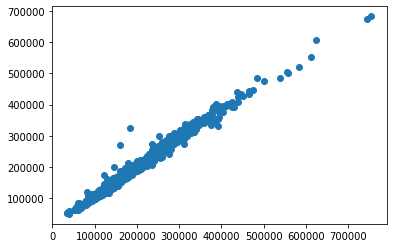

In [22]:
plt.scatter(train_labels, predicted)

In [23]:
predicted = rf.predict(test_features)

In [24]:
predicted

array([125489.878, 154569.454, 177904.988, ..., 151720.912, 112569.71 ,
       230270.622])

In [37]:
ans = pd.DataFrame({'Id':test2['Id'].tolist(), 'SalePrice':predicted.tolist()})

In [42]:
ans.to_csv('submission1.csv', index=False)